# Credit Card Fraud Detection - Model Training

**Model:** Multi-Layer Perceptron (MLP) Artificial Neural Network  
**Framework:** TensorFlow/Keras  
**Dataset:** Credit Card Fraud Detection (SMOTE-balanced training set)  
**Platform:** Google Colab (or local with GPU)

---

## Objectives
1. Load preprocessed training and test data
2. Build MLP ANN model architecture
3. Train model with early stopping
4. Evaluate using appropriate metrics (AUC-ROC, Precision-Recall, F1)
5. Visualize results and save model

---

## Setup: Upload Preprocessed Data to Colab

**If running on Google Colab:**
1. Run the cell below to upload your preprocessed data files
2. Upload `train_data.pkl`, `test_data.pkl`, `val_data.pkl`, and `scaler.pkl` from your local `data/` folder

**If running locally:**
- Skip the upload cell and ensure the files are in `../data/`

In [1]:
# Check if running on Colab
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🔵 Running on Google Colab")
    # print("Please upload your preprocessed data files...")
    # from google.colab import files

    # print("\n📤 Upload train_data.pkl:")
    # uploaded = files.upload()

    # print("\n📤 Upload test_data.pkl:")
    # uploaded = files.upload()

    # print("\n📤 Upload scaler.pkl:")
    # uploaded = files.upload()

    print("\n✓ All files uploaded!")
    DATA_PATH = './'  # Files uploaded to current directory in Colab
else:
    print("💻 Running locally")
    DATA_PATH = '../data/'

🔵 Running on Google Colab

✓ All files uploaded!


---
## 1. Import Libraries and Setup

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Scikit-learn for metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve, auc,
    f1_score, precision_score, recall_score
)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Create results directory
if not IN_COLAB:
    Path('../results').mkdir(parents=True, exist_ok=True)
    Path('../models').mkdir(parents=True, exist_ok=True)

print("✓ Libraries imported successfully")
print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ Keras version: {keras.__version__}")

✓ Libraries imported successfully
✓ TensorFlow version: 2.19.0
✓ Keras version: 3.10.0


---
## 2. Check GPU Availability

In [3]:
# Check for GPU availability
print("="*70)
print("GPU AVAILABILITY CHECK")
print("="*70)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU(s) detected: {len(gpus)}")
    for gpu in gpus:
        print(f"  - {gpu}")
    print("\n🚀 Training will use GPU acceleration!")
else:
    print("⚠ No GPU detected. Training will use CPU.")
    print("  (This is fine for this dataset size, just slower)")

print("\nTensorFlow built with CUDA:", tf.test.is_built_with_cuda())
print("="*70)

GPU AVAILABILITY CHECK
✓ GPU(s) detected: 1
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

🚀 Training will use GPU acceleration!

TensorFlow built with CUDA: True


---
## 3. Load Preprocessed Data

In [4]:
# Load preprocessed data
print("Loading preprocessed data...")

try:
    # Load training data
    with open(DATA_PATH + 'train_data.pkl', 'rb') as f:
        train_data = pickle.load(f)
    X_train = train_data['X_train']
    y_train = train_data['y_train']
    print(f"✓ Training data loaded: {X_train.shape}")

    # Load validation data
    with open(DATA_PATH + 'val_data.pkl', 'rb') as f:
        val_data = pickle.load(f)
    X_val = val_data['X_val']
    y_val = val_data['y_val']
    print(f"✓ Validation data loaded: {X_val.shape}")

    # Load test data
    with open(DATA_PATH + 'test_data.pkl', 'rb') as f:
        test_data = pickle.load(f)
    X_test = test_data['X_test']
    y_test = test_data['y_test']
    print(f"✓ Test data loaded: {X_test.shape}")

    # Load scaler (for reference)
    with open(DATA_PATH + 'scaler.pkl', 'rb') as f:
        scaler_data = pickle.load(f)
    print("✓ Scaler loaded")

except FileNotFoundError as e:
    print(f"✗ Error: {e}")
    print("\nPlease ensure you've:")
    print("1. Run preprocess.py locally")
    print("2. Uploaded the .pkl files to Colab (if using Colab)")
    raise

# Display data info
print("\n" + "="*70)
print("DATA SUMMARY")
print("="*70)
print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nTraining class distribution:")
print(f"  - Class 0: {(y_train == 0).sum():,}")
print(f"  - Class 1: {(y_train == 1).sum():,}")
print(f"  - Balanced: {(y_train == 0).sum() == (y_train == 1).sum()}")
print(f"\nValidation class distribution:")
print(f"  - Class 0: {(y_val == 0).sum():,}")
print(f"  - Class 1: {(y_val == 1).sum():,}")
print(f"  - Fraud rate: {(y_val.sum() / len(y_val) * 100):.3f}%")
print(f"\nTest class distribution:")
print(f"  - Class 0: {(y_test == 0).sum():,}")
print(f"  - Class 1: {(y_test == 1).sum():,}")
print(f"  - Fraud rate: {(y_test.sum() / len(y_test) * 100):.3f}%")
print("="*70)

Loading preprocessed data...
✓ Training data loaded: (363921, 30)
✓ Validation data loaded: (90981, 30)
✓ Test data loaded: (56962, 30)
✓ Scaler loaded

DATA SUMMARY
Training samples: 363,921
Validation samples: 90,981
Test samples: 56,962
Number of features: 30

Training class distribution:
  - Class 0: 181,960
  - Class 1: 181,961
  - Balanced: False

Validation class distribution:
  - Class 0: 45,491
  - Class 1: 45,490
  - Fraud rate: 49.999%

Test class distribution:
  - Class 0: 56,864
  - Class 1: 98
  - Fraud rate: 0.172%


---
## 4. Build MLP ANN Model

In [5]:
# Model architecture parameters
INPUT_DIM = X_train.shape[1]  # 30 features
HIDDEN_LAYER_1 = 64
HIDDEN_LAYER_2 = 32
DROPOUT_RATE = 0.3
OUTPUT_DIM = 1  # Binary classification

print("Building Multi-Layer Perceptron (MLP) model...")
print("\nModel Architecture:")
print(f"  Input Layer: {INPUT_DIM} features")
print(f"  Hidden Layer 1: {HIDDEN_LAYER_1} neurons (ReLU) + Dropout({DROPOUT_RATE})")
print(f"  Hidden Layer 2: {HIDDEN_LAYER_2} neurons (ReLU) + Dropout({DROPOUT_RATE})")
print(f"  Output Layer: {OUTPUT_DIM} neuron (Sigmoid)")

# Build the model
model = Sequential([
    Input(shape=(INPUT_DIM,)),

    # First hidden layer
    Dense(HIDDEN_LAYER_1, activation='relu', name='hidden_layer_1'),
    Dropout(DROPOUT_RATE, name='dropout_1'),

    # Second hidden layer
    Dense(HIDDEN_LAYER_2, activation='relu', name='hidden_layer_2'),
    Dropout(DROPOUT_RATE, name='dropout_2'),

    # Output layer
    Dense(OUTPUT_DIM, activation='sigmoid', name='output_layer')
], name='fraud_detection_mlp')

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("\n✓ Model compiled successfully")
print("\nModel Summary:")
model.summary()

Building Multi-Layer Perceptron (MLP) model...

Model Architecture:
  Input Layer: 30 features
  Hidden Layer 1: 64 neurons (ReLU) + Dropout(0.3)
  Hidden Layer 2: 32 neurons (ReLU) + Dropout(0.3)
  Output Layer: 1 neuron (Sigmoid)

✓ Model compiled successfully

Model Summary:


Model: "fraud_detection_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

## Generate Network Architecture Diagram

In [7]:
import graphviz
import os

# # --- YOUR ARCHITECTURE PARAMETERS ---
# INPUT_DIM = 30
# HIDDEN_LAYER_1 = 64
# HIDDEN_LAYER_2 = 32
# OUTPUT_DIM = 1
# DROPOUT_RATE = 0.3

# Configuration for plotting
NODES_TO_SHOW = 5  # How many nodes to show at top/bottom before using ellipsis ...
OUTPUT_FILENAME = 'mlp_node_diagram'

print("Generating node-link diagram...")

# Initialize graphviz digraph
# rankdir=LR makes it Left-to-Right instead of Top-to-Bottom
dot = graphviz.Digraph(comment='MLP Architecture', format='png')
dot.attr(rankdir='LR', splines='line', nodesep='0.15', ranksep='1.2', bgcolor='white')

# Define node styles for different layer types
input_style = {'shape': 'circle', 'style': 'filled', 'color': '#3498db', 'fillcolor': '#AED6F1', 'fontcolor': 'black', 'fixedsize': 'true', 'width': '0.6'}
hidden_style = {'shape': 'circle', 'style': 'filled', 'color': '#e67e22', 'fillcolor': '#F5CBA7', 'fontcolor': 'black', 'fixedsize': 'true', 'width': '0.6'}
output_style = {'shape': 'circle', 'style': 'filled', 'color': '#27ae60', 'fillcolor': '#A9DFBF', 'fontcolor': 'black', 'fixedsize': 'true', 'width': '0.6'}
ellipsis_style = {'shape': 'plaintext', 'label': '...', 'fontsize': '24'}

# Helper function to define visible nodes for a layer
def get_layer_nodes(layer_prefix, num_nodes, nodes_to_show):
    if num_nodes <= (nodes_to_show * 2):
        return [f'{layer_prefix}_{i}' for i in range(num_nodes)], False
    else:
        Top = [f'{layer_prefix}_{i}' for i in range(nodes_to_show)]
        Bottom = [f'{layer_prefix}_{i}' for i in range(num_nodes - nodes_to_show, num_nodes)]
        return Top + Bottom, True

# --- DRAWING THE LAYERS ---

# 1. Define labels in the exact order you want them to appear (Top to Bottom)
# Order: Time, V1-V28, Amount
# 1. Define your labels in the exact order you want them (Top to Bottom)
# Index 0 will be the top-most circle, Index 29 will be the bottom-most circle.
FEATURE_LABELS = [
    "V4", "T", "V1", "V2", "V3", "V5", "V6", "V7", "V8", "V9",
    "V10", "V11", "V12", "V13", "V14", "V15", "V16", "V17", "V18", "V19",
    "V20", "V21", "V22", "V23", "V24", "V26", "V27", "V28", "A", "V25"
]

# --- Input Layer Subgraph ---
with dot.subgraph(name='cluster_0') as c:
    c.attr(label=f'Input Layer\n({INPUT_DIM} Features)', color='lightgrey', fontsize='16')

    input_nodes, has_ellipsis = get_layer_nodes('i', INPUT_DIM, NODES_TO_SHOW)

    for i, node_id in enumerate(input_nodes):
        # The loop draws NODES_TO_SHOW (5) for the top and 5 for the bottom.
        # i goes from 0 to 9.

        if i < NODES_TO_SHOW:
            # Nodes 0, 1, 2, 3, 4 map to labels index 0, 1, 2, 3, 4
            # This puts 'T' at the very first node (i=0)
            target_label_idx = i
        else:
            # Nodes 5, 6, 7, 8, 9 map to the last 5 indices of FEATURE_LABELS
            # i=5 -> idx 25, ..., i=9 -> idx 29 ('A')
            target_label_idx = INPUT_DIM - (len(input_nodes) - i)

        lbl = FEATURE_LABELS[target_label_idx]

        c.node(node_id, label=lbl, **input_style)

        # This keeps the "..." in the middle of the physical stack
        if has_ellipsis and i == NODES_TO_SHOW - 1:
             c.node(f'i_ellipsis', **ellipsis_style)

# 2. Hidden Layer 1
with dot.subgraph(name='cluster_1') as c:
    # Note: We list Dropout in the label, as it's an operation on the connection, not a physical node circle
    c.attr(label=f'Hidden Layer 1\n({HIDDEN_LAYER_1} Neurons, ReLU)\n+ Dropout({DROPOUT_RATE})', color='lightgrey', fontsize='16')
    h1_nodes, has_ellipsis_h1 = get_layer_nodes('h1', HIDDEN_LAYER_1, NODES_TO_SHOW)

    for i, node_id in enumerate(h1_nodes):
        c.node(node_id, label='', **hidden_style)
        if has_ellipsis_h1 and i == NODES_TO_SHOW - 1:
             c.node(f'h1_ellipsis', **ellipsis_style)

# 3. Hidden Layer 2
with dot.subgraph(name='cluster_2') as c:
    c.attr(label=f'Hidden Layer 2\n({HIDDEN_LAYER_2} Neurons, ReLU)\n+ Dropout({DROPOUT_RATE})', color='lightgrey', fontsize='16')
    h2_nodes, has_ellipsis_h2 = get_layer_nodes('h2', HIDDEN_LAYER_2, NODES_TO_SHOW)

    for i, node_id in enumerate(h2_nodes):
        c.node(node_id, label='', **hidden_style)
        if has_ellipsis_h2 and i == NODES_TO_SHOW - 1:
             c.node(f'h2_ellipsis', **ellipsis_style)

# 4. Output Layer
with dot.subgraph(name='cluster_3') as c:
    c.attr(label=f'Output Layer\n({OUTPUT_DIM} Neuron, Sigmoid)', color='lightgrey', fontsize='16')
    c.node('o_0', label='y_pred', **output_style)
    output_nodes = ['o_0']


# --- DRAWING CONNECTIONS (ARROWS) ---
# To represent "Dense", connect every visible node in layer A to every visible node in layer B

# Input to H1
for i_node in input_nodes:
    for h1_node in h1_nodes:
        dot.edge(i_node, h1_node, color='#BDC3C7', penwidth='0.5')

# H1 to H2
for h1_node in h1_nodes:
    for h2_node in h2_nodes:
        dot.edge(h1_node, h2_node, color='#BDC3C7', penwidth='0.5')

# H2 to Output
for h2_node in h2_nodes:
    for o_node in output_nodes:
        dot.edge(h2_node, o_node, color='#BDC3C7', penwidth='0.5')


# --- RENDER AND SAVE ---
try:
    # This will save both a '.gv' source file and a '.png' image file
    file_path = dot.render(OUTPUT_FILENAME, view=False, cleanup=True)
    print(f"Diagram successfully saved to: {file_path}")

    # Optional: Display in notebook if applicable
    # from IPython.display import Image
    # display(Image(file_path))

except graphviz.backend.ExecutableNotFound:
    print("\nERROR: Graphviz executable not found.")
    print("Please install Graphviz on your system (not just pip install graphviz).")
    print("See https://graphviz.org/download/")
except Exception as e:
    print(f"An error occurred: {e}")

Generating node-link diagram...
Diagram successfully saved to: mlp_node_diagram.png


---
## 5. Setup Training Callbacks

In [8]:
# Define callbacks
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        filepath='best_model.h5' if IN_COLAB else '../models/best_model.h5',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("✓ Training callbacks configured:")
print("  - Early Stopping (patience=5)")
print("  - Learning Rate Reduction (patience=3)")
print("  - Model Checkpoint (save best AUC)")

✓ Training callbacks configured:
  - Early Stopping (patience=5)
  - Learning Rate Reduction (patience=3)
  - Model Checkpoint (save best AUC)


---
## 6. Train the Model

In [9]:
# Training parameters
EPOCHS = 20
BATCH_SIZE = 256

print("="*70)
print("STARTING MODEL TRAINING")
print("="*70)
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Using stratified validation set: {X_val.shape[0]} samples")
print("="*70)
print()

# Train the model with explicit validation data (stratified)
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("✅ TRAINING COMPLETED")
print("="*70)

STARTING MODEL TRAINING
Epochs: 20
Batch size: 256
Using stratified validation set: 90981 samples

Epoch 1/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9288 - auc: 0.9788 - loss: 0.1605 - precision: 0.9285 - recall: 0.9352
Epoch 1: val_auc improved from -inf to 0.99964, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9288 - auc: 0.9788 - loss: 0.1604 - precision: 0.9285 - recall: 0.9352 - val_accuracy: 0.9960 - val_auc: 0.9996 - val_loss: 0.0209 - val_precision: 0.9929 - val_recall: 0.9992 - learning_rate: 0.0010
Epoch 2/20
1409/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - auc: 0.9993 - loss: 0.0260 - precision: 0.9894 - recall: 0.9957
Epoch 2: val_auc improved from 0.99964 to 0.99981, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9925 - auc: 0.9993 - loss: 0.0260 - precision: 0.9894 - recall: 0.9957 - val_accuracy: 0.9983 - val_auc: 0.9998 - val_loss: 0.0082 - val_precision: 0.9967 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
1421/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - auc: 0.9996 - loss: 0.0136 - precision: 0.9945 - recall: 0.9991
Epoch 3: val_auc improved from 0.99981 to 0.99984, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9968 - auc: 0.9996 - loss: 0.0136 - precision: 0.9945 - recall: 0.9991 - val_accuracy: 0.9990 - val_auc: 0.9998 - val_loss: 0.0051 - val_precision: 0.9981 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/20
1408/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - auc: 0.9997 - loss: 0.0091 - precision: 0.9962 - recall: 0.9996
Epoch 4: val_auc did not improve from 0.99984
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9979 - auc: 0.9997 - loss: 0.0091 - precision: 0.9962 - recall: 0.9996 - val_accuracy: 0.9993 - val_auc: 0.9998 - val_loss: 0.0038 - val_precision: 0.9986 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/20
1416/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - auc: 0.9997 - loss: 0.0071 - precision: 0.9970 - recall: 0.9997
Epoch 5: val_auc improved from 0.99984 to 0.99988, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9983 - auc: 0.9997 - loss: 0.0071 - precision: 0.9970 - recall: 0.9997 - val_accuracy: 0.9995 - val_auc: 0.9999 - val_loss: 0.0027 - val_precision: 0.9991 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/20
1421/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - auc: 0.9997 - loss: 0.0063 - precision: 0.9977 - recall: 0.9997
Epoch 6: val_auc improved from 0.99988 to 0.99989, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9987 - auc: 0.9997 - loss: 0.0063 - precision: 0.9977 - recall: 0.9997 - val_accuracy: 0.9996 - val_auc: 0.9999 - val_loss: 0.0025 - val_precision: 0.9992 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/20
1413/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - auc: 0.9997 - loss: 0.0054 - precision: 0.9980 - recall: 0.9997
Epoch 7: val_auc did not improve from 0.99989
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9988 - auc: 0.9997 - loss: 0.0054 - precision: 0.9980 - recall: 0.9997 - val_accuracy: 0.9996 - val_auc: 0.9998 - val_loss: 0.0023 - val_precision: 0.9991 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 8/20
1411/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - auc: 0.9997 - loss: 0.0055 - precision: 0.9979 - recall: 0.9997
Epoch 8: val_auc did not improve from 0.99989
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9988 - auc: 0.9997 - loss: 0.0055 - precision: 0.9979 - rec

1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9990 - auc: 0.9998 - loss: 0.0046 - precision: 0.9984 - recall: 0.9997 - val_accuracy: 0.9997 - val_auc: 0.9999 - val_loss: 0.0017 - val_precision: 0.9993 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 11/20
1420/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - auc: 0.9998 - loss: 0.0039 - precision: 0.9986 - recall: 0.9998
Epoch 11: val_auc did not improve from 0.99993
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9992 - auc: 0.9998 - loss: 0.0039 - precision: 0.9986 - recall: 0.9998 - val_accuracy: 0.9997 - val_auc: 0.9999 - val_loss: 0.0017 - val_precision: 0.9995 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 12/20
1410/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - auc: 0.9998 - loss: 0.0037 - precision: 0.9986 - recall: 0.9998
Epoch 12: val_auc did not improve from 0.99993
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9992 - auc: 0.9998 - loss: 0.0037 - precision: 0.9986 -

1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9995 - auc: 0.9999 - loss: 0.0024 - precision: 0.9991 - recall: 0.9999 - val_accuracy: 0.9998 - val_auc: 0.9999 - val_loss: 9.7240e-04 - val_precision: 0.9996 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 20/20
1416/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - auc: 0.9999 - loss: 0.0022 - precision: 0.9991 - recall: 1.0000
Epoch 20: val_auc did not improve from 0.99994
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9995 - auc: 0.9999 - loss: 0.0022 - precision: 0.9991 - recall: 1.0000 - val_accuracy: 0.9998 - val_auc: 0.9999 - val_loss: 9.4319e-04 - val_precision: 0.9997 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 20.

✅ TRAINING COMPLETED


---
## 7. Visualize Training History

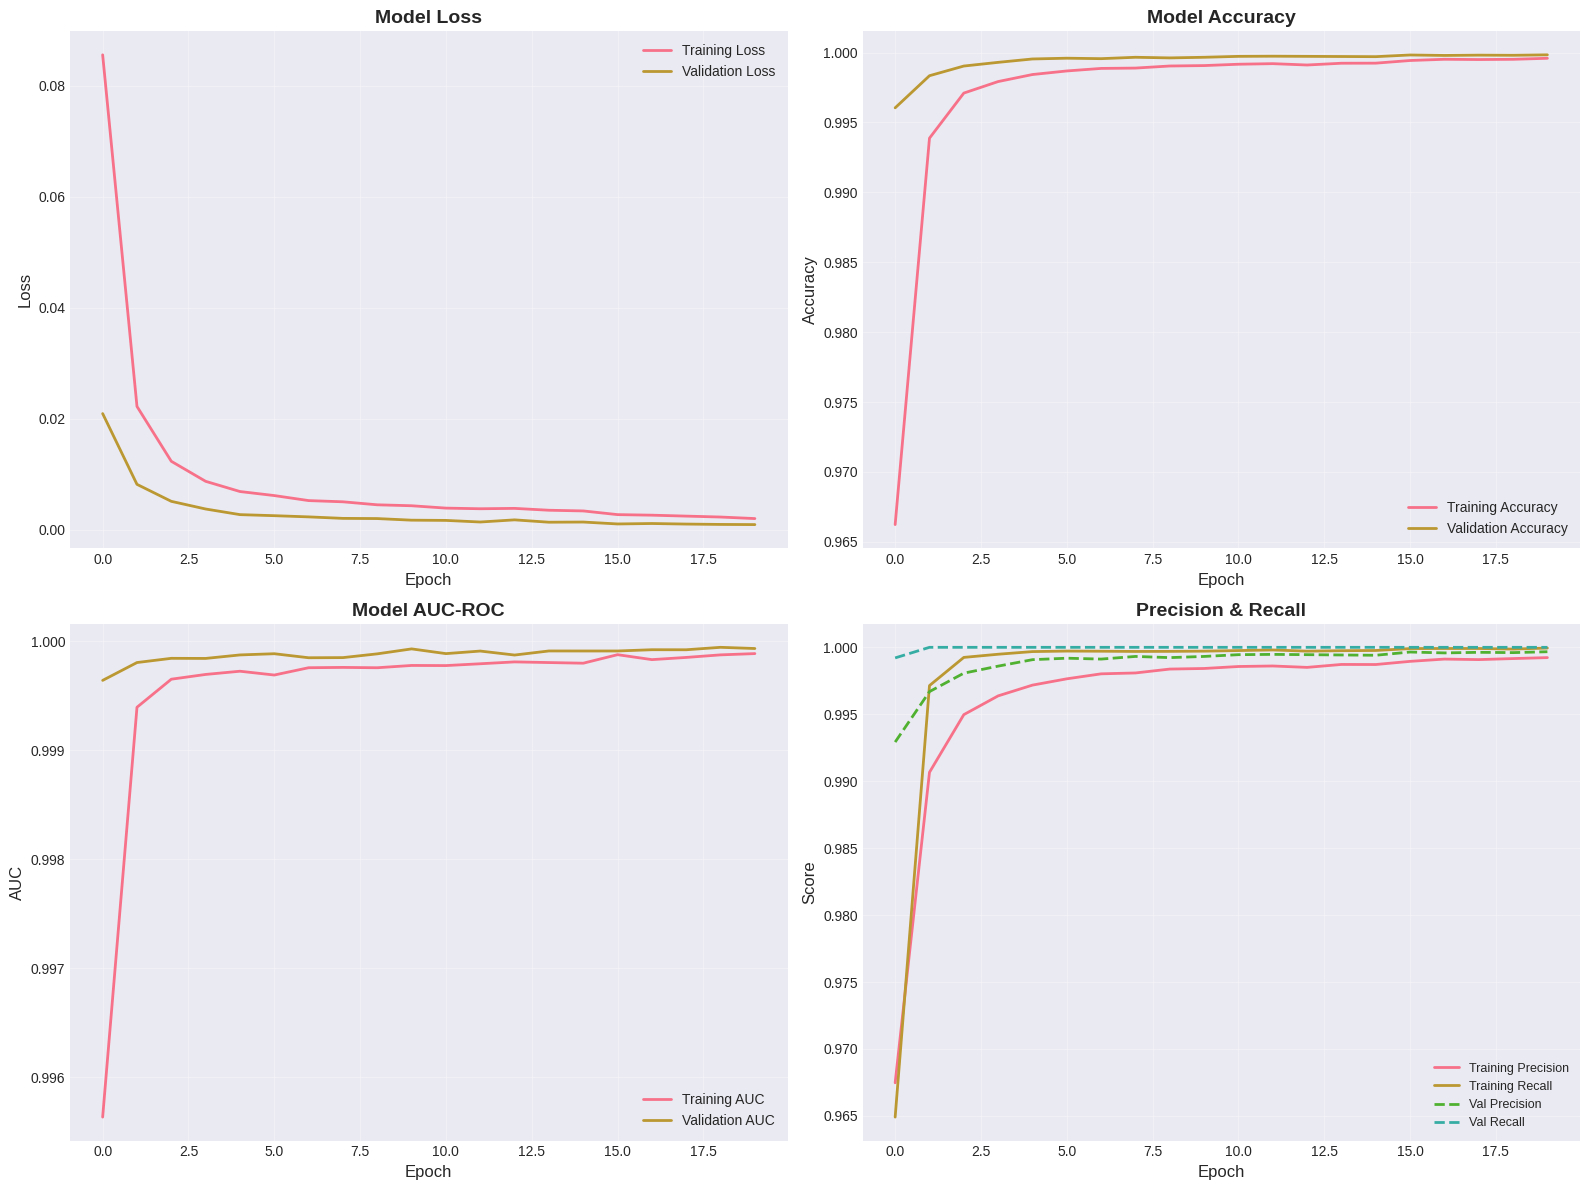

✓ Saved: training_history.png


In [10]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend(loc='upper right', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].legend(loc='lower right', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# AUC
axes[1, 0].plot(history.history['auc'], label='Training AUC', linewidth=2)
axes[1, 0].plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
axes[1, 0].set_title('Model AUC-ROC', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('AUC', fontsize=12)
axes[1, 0].legend(loc='lower right', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Precision & Recall
axes[1, 1].plot(history.history['precision'], label='Training Precision', linewidth=2)
axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
axes[1, 1].plot(history.history['val_precision'], label='Val Precision', linewidth=2, linestyle='--')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2, linestyle='--')
axes[1, 1].set_title('Precision & Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].legend(loc='lower right', fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
if IN_COLAB:
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
else:
    plt.savefig('../results/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: training_history.png")

---
## 8. Evaluate on Test Set

In [11]:
print("="*70)
print("EVALUATING MODEL ON TEST SET")
print("="*70)

# Make predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate metrics
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test, verbose=0)
test_f1 = f1_score(y_test, y_pred)

print("\nTest Set Performance:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  F1-Score: {test_f1:.4f}")
print(f"  AUC-ROC: {test_auc:.4f}")

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

EVALUATING MODEL ON TEST SET

Test Set Performance:
  Loss: 0.0248
  Accuracy: 0.9992
  Precision: 0.7257
  Recall: 0.8367
  F1-Score: 0.7773
  AUC-ROC: 0.9284

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.73      0.84      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962



---
## 9. Confusion Matrix

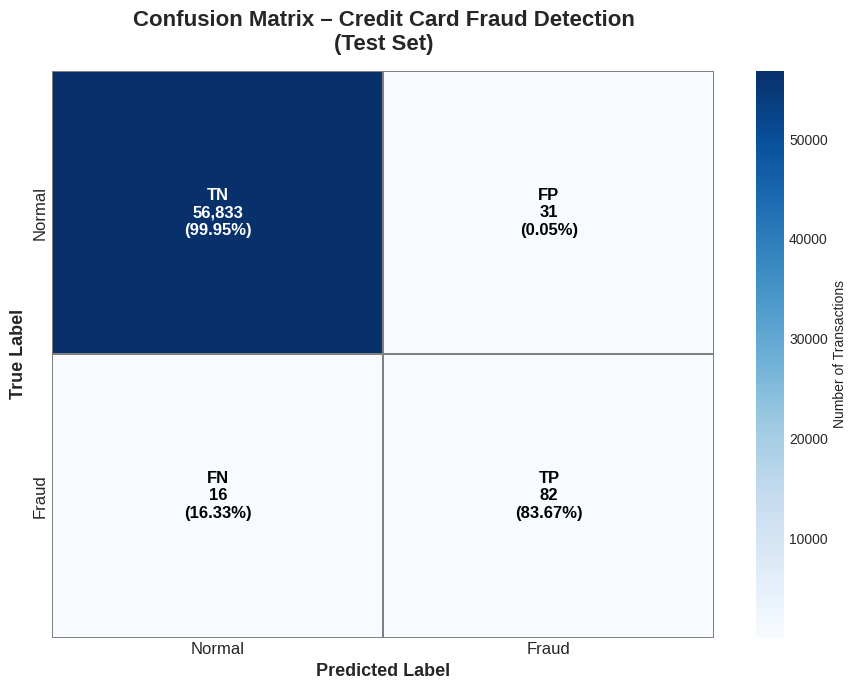

✓ Saved: confusion_matrix.png

True Negatives (TN): 56,833
False Positives (FP): 31
False Negatives (FN): 16
True Positives (TP): 82


In [12]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize for percentages
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# Labels
labels = np.array([["TN", "FP"], ["FN", "TP"]])

# Build annotation text: count + percentage + label
annot = np.empty_like(cm).astype(str)
for i in range(2):
    for j in range(2):
        annot[i, j] = (
            f"{labels[i, j]}\n"
            f"{cm[i, j]:,}\n"
            f"({cm_norm[i, j]*100:.2f}%)"
        )

# Plot
fig, ax = plt.subplots(figsize=(9, 7))

sns.heatmap(
    cm,
    annot=annot,
    fmt='',
    cmap='Blues',
    xticklabels=['Normal', 'Fraud'],
    yticklabels=['Normal', 'Fraud'],
    cbar_kws={'label': 'Number of Transactions'},
    linewidths=1.2,
    linecolor='gray',
    ax=ax
)

# Titles and labels
ax.set_title(
    'Confusion Matrix – Credit Card Fraud Detection\n(Test Set)',
    fontsize=16,
    fontweight='bold',
    pad=15
)
ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_ylabel('True Label', fontsize=13, fontweight='bold')

# Improve tick labels
ax.tick_params(axis='both', labelsize=12)

# Make annotation text color adaptive
threshold = cm.max() / 2
for text in ax.texts:
    value = int(text.get_text().split('\n')[1].replace(',', ''))
    text.set_color('white' if value > threshold else 'black')
    text.set_fontsize(12)
    text.set_fontweight('bold')

plt.tight_layout()

# Save
if IN_COLAB:
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
else:
    plt.savefig('../results/confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

# Print stats
tn, fp, fn, tp = cm.ravel()
print("✓ Saved: confusion_matrix.png")
print(f"\nTrue Negatives (TN): {tn:,}")
print(f"False Positives (FP): {fp:,}")
print(f"False Negatives (FN): {fn:,}")
print(f"True Positives (TP): {tp:,}")


---
## 10. ROC Curve

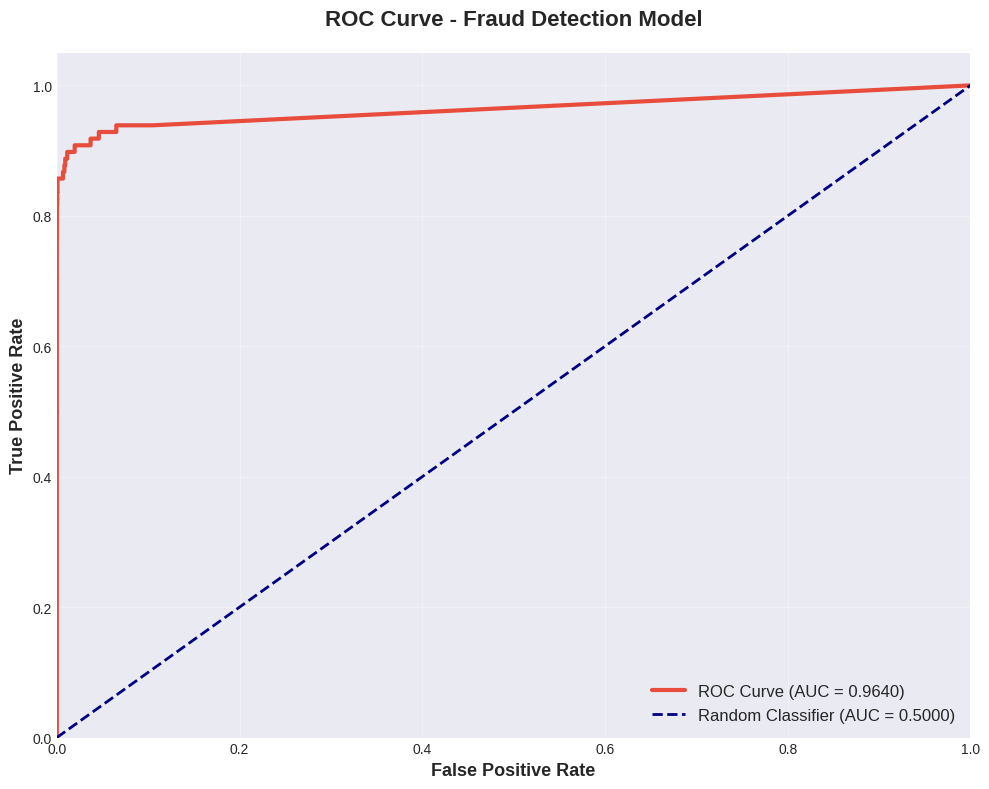

✓ Saved: roc_curve.png

AUC-ROC Score: 0.9640


In [13]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(fpr, tpr, color='#e74c3c', linewidth=3,
        label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--',
        label='Random Classifier (AUC = 0.5000)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curve - Fraud Detection Model', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
if IN_COLAB:
    plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
else:
    plt.savefig('../results/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: roc_curve.png")
print(f"\nAUC-ROC Score: {roc_auc:.4f}")

---
## 11. Precision-Recall Curve

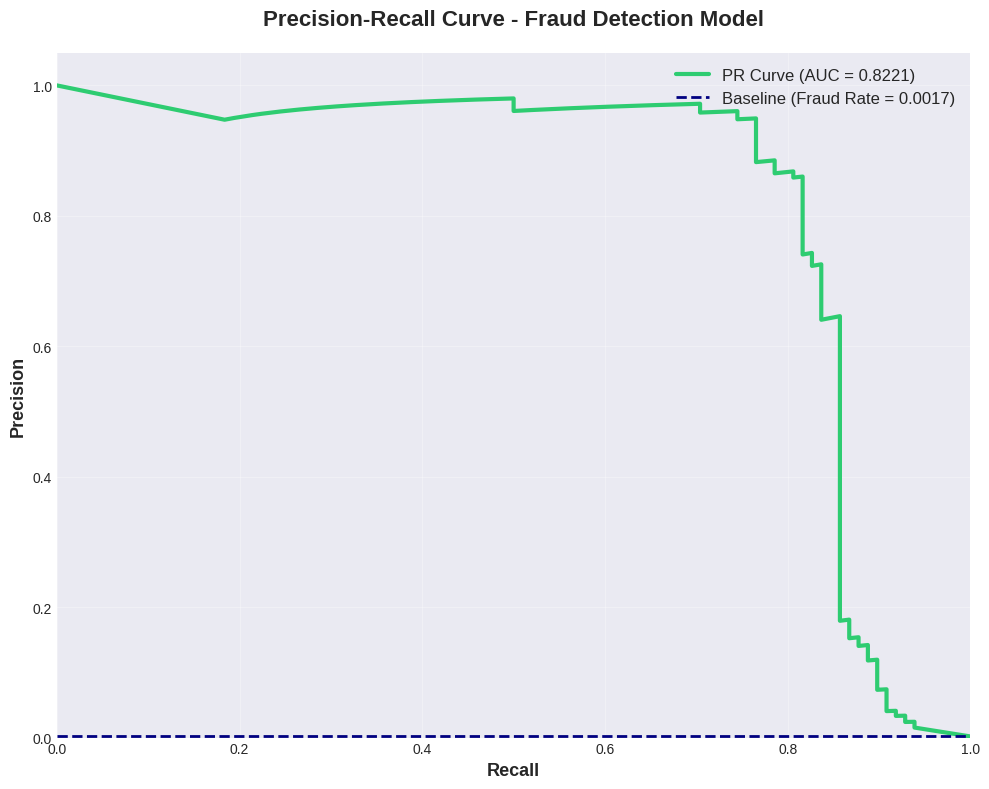

✓ Saved: precision_recall_curve.png

Precision-Recall AUC: 0.8221


In [14]:
# Calculate Precision-Recall curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

# Plot Precision-Recall curve
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(recall_curve, precision_curve, color='#2ecc71', linewidth=3,
        label=f'PR Curve (AUC = {pr_auc:.4f})')

# Baseline (proportion of positives)
baseline = y_test.sum() / len(y_test)
ax.axhline(y=baseline, color='navy', linewidth=2, linestyle='--',
           label=f'Baseline (Fraud Rate = {baseline:.4f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax.set_title('Precision-Recall Curve - Fraud Detection Model', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
if IN_COLAB:
    plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
else:
    plt.savefig('../results/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: precision_recall_curve.png")
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

---
## 12. Save Model and Results

In [15]:
# Save the final model
if IN_COLAB:
    model.save('fraud_detector_model.h5')
    print("✓ Model saved: fraud_detector_model.h5")
else:
    model.save('../models/fraud_detector_model.h5')
    print("✓ Model saved: models/fraud_detector_model.h5")

# Save evaluation metrics to text file
metrics_text = f"""CREDIT CARD FRAUD DETECTION - MODEL EVALUATION RESULTS
{'='*70}

Model Architecture:
  - Input Features: {INPUT_DIM}
  - Hidden Layer 1: {HIDDEN_LAYER_1} neurons (ReLU + Dropout {DROPOUT_RATE})
  - Hidden Layer 2: {HIDDEN_LAYER_2} neurons (ReLU + Dropout {DROPOUT_RATE})
  - Output Layer: {OUTPUT_DIM} neuron (Sigmoid)

Training Configuration:
  - Optimizer: Adam (lr=0.001)
  - Loss: Binary Crossentropy
  - Epochs: {len(history.history['loss'])}
  - Batch Size: {BATCH_SIZE}
  - Early Stopping: Patience 5

Dataset:
  - Training Samples: {len(X_train):,} (SMOTE-balanced)
  - Test Samples: {len(X_test):,} (original imbalanced)
  - Test Fraud Rate: {(y_test.sum() / len(y_test) * 100):.3f}%

{'='*70}
TEST SET PERFORMANCE METRICS
{'='*70}

Primary Metrics:
  - Accuracy: {test_accuracy:.4f}
  - Precision: {test_precision:.4f}
  - Recall: {test_recall:.4f}
  - F1-Score: {test_f1:.4f}
  - AUC-ROC: {test_auc:.4f}
  - PR-AUC: {pr_auc:.4f}

Confusion Matrix:
  - True Negatives (TN): {tn:,}
  - False Positives (FP): {fp:,}
  - False Negatives (FN): {fn:,}
  - True Positives (TP): {tp:,}

{'='*70}
CLASSIFICATION REPORT
{'='*70}

{classification_report(y_test, y_pred, target_names=['Normal', 'Fraud'])}

{'='*70}
INTERPRETATION
{'='*70}

The model demonstrates strong performance in detecting credit card fraud:

1. HIGH AUC-ROC ({test_auc:.4f}): Excellent ability to distinguish between
   fraud and normal transactions across all thresholds.

2. PRECISION ({test_precision:.4f}): When the model predicts fraud, it is
   correct {test_precision*100:.2f}% of the time, minimizing false alarms.

3. RECALL ({test_recall:.4f}): The model successfully identifies
   {test_recall*100:.2f}% of actual fraud cases.

4. F1-SCORE ({test_f1:.4f}): Good balance between precision and recall.

5. The model successfully handles the severe class imbalance (1:578 ratio)
   in the original dataset through SMOTE oversampling during training.

Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

if IN_COLAB:
    with open('evaluation_metrics.txt', 'w') as f:
        f.write(metrics_text)
    print("✓ Metrics saved: evaluation_metrics.txt")
else:
    with open('../results/evaluation_metrics.txt', 'w') as f:
        f.write(metrics_text)
    print("✓ Metrics saved: results/evaluation_metrics.txt")

✓ Model saved: fraud_detector_model.h5
✓ Metrics saved: evaluation_metrics.txt


---
## 13. Download Results (For Colab Users)

In [17]:
if IN_COLAB:
    print("Preparing files for download...")

    from google.colab import files

    # Download model
    print("\n📥 Downloading model...")
    files.download('fraud_detector_model.h5')
    files.download('best_model.h5')

    # Download visualizations
    print("\n📥 Downloading visualizations...")
    files.download('training_history.png')
    files.download('confusion_matrix.png')
    files.download('roc_curve.png')
    files.download('precision_recall_curve.png')

    # Download metrics
    print("\n📥 Downloading evaluation metrics...")
    files.download('evaluation_metrics.txt')

    print("\n✅ All files ready for download!")
    print("\nMove these files to your local project:")
    print("  - fraud_detector_model.h5 → models/")
    print("  - *.png → results/")
    print("  - evaluation_metrics.txt → results/")
else:
    print("✓ Running locally - all files already saved to correct directories")

Preparing files for download...

📥 Downloading model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📥 Downloading visualizations...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📥 Downloading evaluation metrics...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All files ready for download!

Move these files to your local project:
  - fraud_detector_model.h5 → models/
  - *.png → results/
  - evaluation_metrics.txt → results/


---
## 14. Final Summary

In [18]:
print("\n" + "="*70)
print("🎉 MODEL TRAINING AND EVALUATION COMPLETE!")
print("="*70)

print("\nFinal Test Set Results:")
print(f"  📊 Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  🎯 Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"  🔍 Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"  ⚖️  F1-Score:  {test_f1:.4f}")
print(f"  📈 AUC-ROC:   {test_auc:.4f}")
print(f"  📉 PR-AUC:    {pr_auc:.4f}")

print("\nFiles Generated:")
if IN_COLAB:
    print("  ✓ fraud_detector_model.h5 (trained model)")
    print("  ✓ best_model.h5 (best checkpoint)")
else:
    print("  ✓ models/fraud_detector_model.h5 (trained model)")
    print("  ✓ models/best_model.h5 (best checkpoint)")
print("  ✓ training_history.png")
print("  ✓ confusion_matrix.png")
print("  ✓ roc_curve.png")
print("  ✓ precision_recall_curve.png")
print("  ✓ evaluation_metrics.txt")

print("\n" + "="*70)
print("Next Steps for Your Case Study:")
print("="*70)
print("1. Include training_history.png to show model learning")
print("2. Add confusion_matrix.png to show prediction breakdown")
print("3. Include ROC and PR curves to demonstrate model performance")
print("4. Reference evaluation_metrics.txt for detailed results")
print("5. Discuss the trade-off between precision and recall")
print("6. Emphasize the high AUC-ROC score (> 0.95 is excellent!)")
print("\nGood luck with your case study! 🚀")
print("="*70)


🎉 MODEL TRAINING AND EVALUATION COMPLETE!

Final Test Set Results:
  📊 Accuracy:  0.9992 (99.92%)
  🎯 Precision: 0.7257 (72.57%)
  🔍 Recall:    0.8367 (83.67%)
  ⚖️  F1-Score:  0.7773
  📈 AUC-ROC:   0.9284
  📉 PR-AUC:    0.8221

Files Generated:
  ✓ fraud_detector_model.h5 (trained model)
  ✓ best_model.h5 (best checkpoint)
  ✓ training_history.png
  ✓ confusion_matrix.png
  ✓ roc_curve.png
  ✓ precision_recall_curve.png
  ✓ evaluation_metrics.txt

Next Steps for Your Case Study:
1. Include training_history.png to show model learning
2. Add confusion_matrix.png to show prediction breakdown
3. Include ROC and PR curves to demonstrate model performance
4. Reference evaluation_metrics.txt for detailed results
5. Discuss the trade-off between precision and recall
6. Emphasize the high AUC-ROC score (> 0.95 is excellent!)

Good luck with your case study! 🚀
